In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Flatten, Concatenate
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import load_dataset

In [ ]:
data = load_dataset('lmms-lab/ai2d')

README.md:   0%|          | 0.00/700 [00:00<?, ?B/s]

test-00000-of-00002.parquet:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

test-00001-of-00002.parquet:   0%|          | 0.00/77.2M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/3088 [00:00<?, ? examples/s]

In [ ]:
data['test'][5]

{'question': 'Based on the given diagram, the penguin is a',
 'options': ['Decomposer', 'Predator', 'Herbivore', 'Plant'],
 'answer': '1',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=576x396>}

Question: Based on the given diagram, the penguin is a
Options: ['Decomposer', 'Predator', 'Herbivore', 'Plant']
Answer: 1


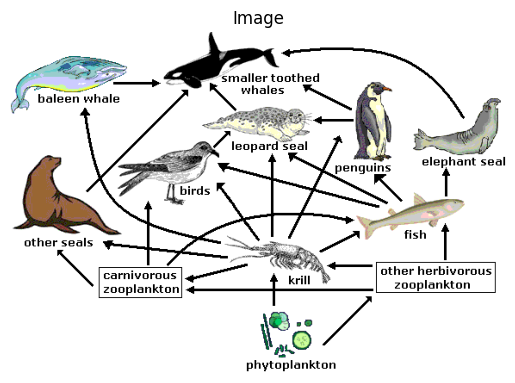

In [ ]:
data_point = data['test'][5]

for key, value in data_point.items():
    if key != 'image':
        print(f"{key.title()}: {value}")

plt.imshow(data_point['image'])
plt.title("Image")
plt.axis('off')
plt.show()

Image Preprocessing

In [ ]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img).astype('float32') / 255.0
    return img


Text Preprocessing

In [ ]:
dataset = data['test']

texts = []
labels = []
questions = []
options_all = []

for item in dataset:
    q = item['question']
    opts = item['options']
    ans = int(item['answer'])

    # Store each option as "question + option"
    q_opts = [f"{q} {opt}" for opt in opts]
    texts.extend(q_opts)

    labels.append(ans)
    questions.append(q)
    options_all.append(opts)

In [ ]:
len(texts)

12352

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

In [ ]:
MAX_LEN = 30  # set based on your text length

# Tokenize and pad each group of 4 options per question
encoded_qopts = []
for i in range(0, len(texts), 4):  # 4 options per question
    group = texts[i:i+4]
    seq = tokenizer.texts_to_sequences(group)
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    encoded_qopts.append(padded)  # shape: (4, MAX_LEN)

In [ ]:
encoded_qopts[0]

array([[   6,    5,   63,  530, 1723,  885,   30,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   6,    5,   63,  530, 1723,  885,   34,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   6,    5,   63,  530, 1723,  885,   27,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   6,    5,   63,  530, 1723,  885,    8,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
# Already created as `labels`, make sure they are integers
labels = [int(label) for label in labels]
labels = np.array(labels)

In [ ]:
 # Import GlobalAveragePooling2D

# DenseNet201 setup
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add GlobalAveragePooling2D layer to flatten the features
fe = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.layers[-2].output))

# Image feature extraction (outside the TensorFlow graph)
img_size = 224
features = []

# Iterate through the dataset using tqdm for progress visualization
for item in tqdm(data['test'], desc="Extracting features"):
    pil_img = item['image'].resize((img_size, img_size))
    img = img_to_array(pil_img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Predict features without verbose output
    feature = fe.predict(img, verbose=0)
    features.append(feature.squeeze())

# Now, proceed with your training process as before using the extracted features

Extracting features: 100%|██████████| 3088/3088 [06:09<00:00,  8.35it/s]


In [ ]:


VOCAB_SIZE = 10000
MAX_LEN = 30

# Text input
text_input = Input(shape=(4, MAX_LEN), name="text_input")  # (batch, 4, 30)
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=128)

# Embed each option
embedded = TimeDistributed(embedding_layer)(text_input)  # (batch, 4, 30, 128)

# LSTM on each option
lstm_out = TimeDistributed(LSTM(64))(embedded)  # (batch, 4, 64)

# Flatten text features
flat_text = Flatten()(lstm_out)  # (batch, 256)

# Image input
image_input = Input(shape=(1920,), name="image_input")  # (batch, 1920)

# Combine
combined = Concatenate()([flat_text, image_input])

# Dense layers
x = Dense(256, activation='relu')(combined)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Build and compile
model = Model(inputs=[text_input, image_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 4, 30)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4, 30,     │  1,280,000 │ text_input[0][0]  │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 4, 64)     │     49,408 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2176)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    557,312 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        516 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,920,132 (7.32 MB)

 Trainable params: 1,920,132 (7.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare the data for text and image features
text_input_data = np.array(encoded_qopts)  # shape: (num_samples, 4, MAX_LEN)
image_input_data = np.array(features)  # shape: (num_samples, 1920)
labels = np.array(labels)  # shape: (num_samples,)

text_input_data = np.array(text_input_data, dtype=np.int32)
image_input_data = np.array(image_input_data, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)
# Ensure image_input_data has the correct shape
image_input_data = image_input_data.reshape(image_input_data.shape[0], 1920)

# Train the model


In [ ]:
history = model.fit([text_input_data, image_input_data], labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7050 - loss: 0.7380 - val_accuracy: 0.2621 - val_loss: 2.0356
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7373 - loss: 0.6303 - val_accuracy: 0.2557 - val_loss: 2.5124
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7859 - loss: 0.5374 - val_accuracy: 0.2670 - val_loss: 2.7232
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8037 - loss: 0.4766 - val_accuracy: 0.2702 - val_loss: 2.5350
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8616 - loss: 0.3742 - val_accuracy: 0.2896 - val_loss: 2.8844
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8747 - loss: 0.3219 - val_accuracy: 0.2654 - val_loss: 3.6272
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9111 - loss: 0.2340 - val_accuracy: 0.2670 - val_loss: 3.5229
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9304 - loss: 0.2050 - val_accuracy: 0.

In [ ]:
np.unique(labels, return_counts=True)


(array([0, 1, 2, 3], dtype=int32), array([758, 802, 832, 696]))

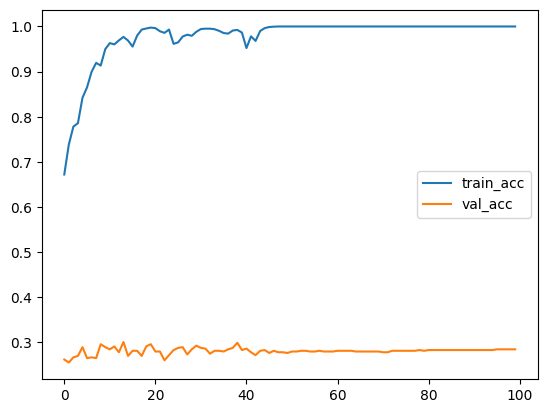

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
 # Import load_img
def predict_answer(image_path, question, options, model, tokenizer, fe_model, max_len=30, img_size=224):
    # --- Image feature extraction ---
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.
    img = np.expand_dims(img, axis=0)
    img_feat = fe_model.predict(img, verbose=0).reshape(1, -1)  # shape (1, 1920)

    # --- Text preprocessing ---
    qopts = [question + " " + opt for opt in options]
    tokens = tokenizer.texts_to_sequences(qopts)
    padded = pad_sequences(tokens, maxlen=max_len, padding='post')
    text_feat = np.array(padded).reshape(1, 4, max_len)  # shape (1, 4, max_len)

    # --- Prediction ---
    pred = model.predict([text_feat, img_feat])
    predicted_idx = np.argmax(pred)

    return options[predicted_idx]

In [ ]:
question = "Based on the given diagram, the penguin is a"
options = ['Decomposer', 'Predator', 'Herbivore', 'Plant']
image_path = "/content/peguin.jpg"

predicted = predict_answer(image_path, question, options, model, tokenizer, fe)
print("Predicted Answer:", predicted)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Predicted Answer: Decomposer


In [ ]:
question = "Based on the given diagram, which animal is this"
options = ['Tiger', 'Lion', 'Horse', 'Dog']
image_path = "/content/pengu.jpeg"

predicted = predict_answer(image_path, question, options, model, tokenizer, fe)
print("Predicted Answer:", predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Answer: Horse


In [ ]:
model.save('my_vqa_model.h5')